# Outline

The idea is to use a bidirectional model such as BERT or XLNet to get the attention maps. The attention maps define edge feature matrixes of the size (n_layer, n_head). The idea is then to prune this graph to obtain a usable KG. 

What do we really mean by a "usable KG" though?

In [7]:
from transformers import XLNetTokenizer, XLNetModel
import torch

import numpy as np
import json

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Load XLNet Base Model and Tokenizer:

In [8]:
# Load tokenizer:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

# Load model and print configurations:
model = XLNetModel.from_pretrained('xlnet-base-cased')

# Make sure that the model outputs the attention maps:
model.config.output_attentions = True  

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
# Print model configs:
print(json.dumps(model.config.to_dict(), indent=4))

{
    "vocab_size": 32000,
    "d_model": 768,
    "n_layer": 12,
    "n_head": 12,
    "d_head": 64,
    "ff_activation": "gelu",
    "d_inner": 3072,
    "untie_r": true,
    "attn_type": "bi",
    "initializer_range": 0.02,
    "layer_norm_eps": 1e-12,
    "dropout": 0.1,
    "mem_len": null,
    "reuse_len": null,
    "bi_data": false,
    "clamp_len": -1,
    "same_length": false,
    "summary_type": "last",
    "summary_use_proj": true,
    "summary_activation": "tanh",
    "summary_last_dropout": 0.1,
    "start_n_top": 5,
    "end_n_top": 5,
    "bos_token_id": 1,
    "pad_token_id": 5,
    "eos_token_id": 2,
    "use_mems_eval": true,
    "use_mems_train": false,
    "return_dict": true,
    "output_hidden_states": false,
    "output_attentions": true,
    "torchscript": false,
    "torch_dtype": null,
    "use_bfloat16": false,
    "tf_legacy_loss": false,
    "pruned_heads": {},
    "tie_word_embeddings": true,
    "is_encoder_decoder": false,
    "is_decoder": false,
    "c

# Run the Model on an Input:

In [10]:
input_str = "A scientific statement is an official point of view or belief that may or may not contain clinical or research recommendations."
inputs = tokenizer(input_str, return_tensors="pt")

In [11]:
outputs = model(**inputs)
print(outputs.keys())
print(len(outputs["attentions"]))
print(outputs["attentions"][0].shape)

odict_keys(['last_hidden_state', 'mems', 'attentions'])
12
torch.Size([1, 12, 24, 24])


# Print Attention Maps 

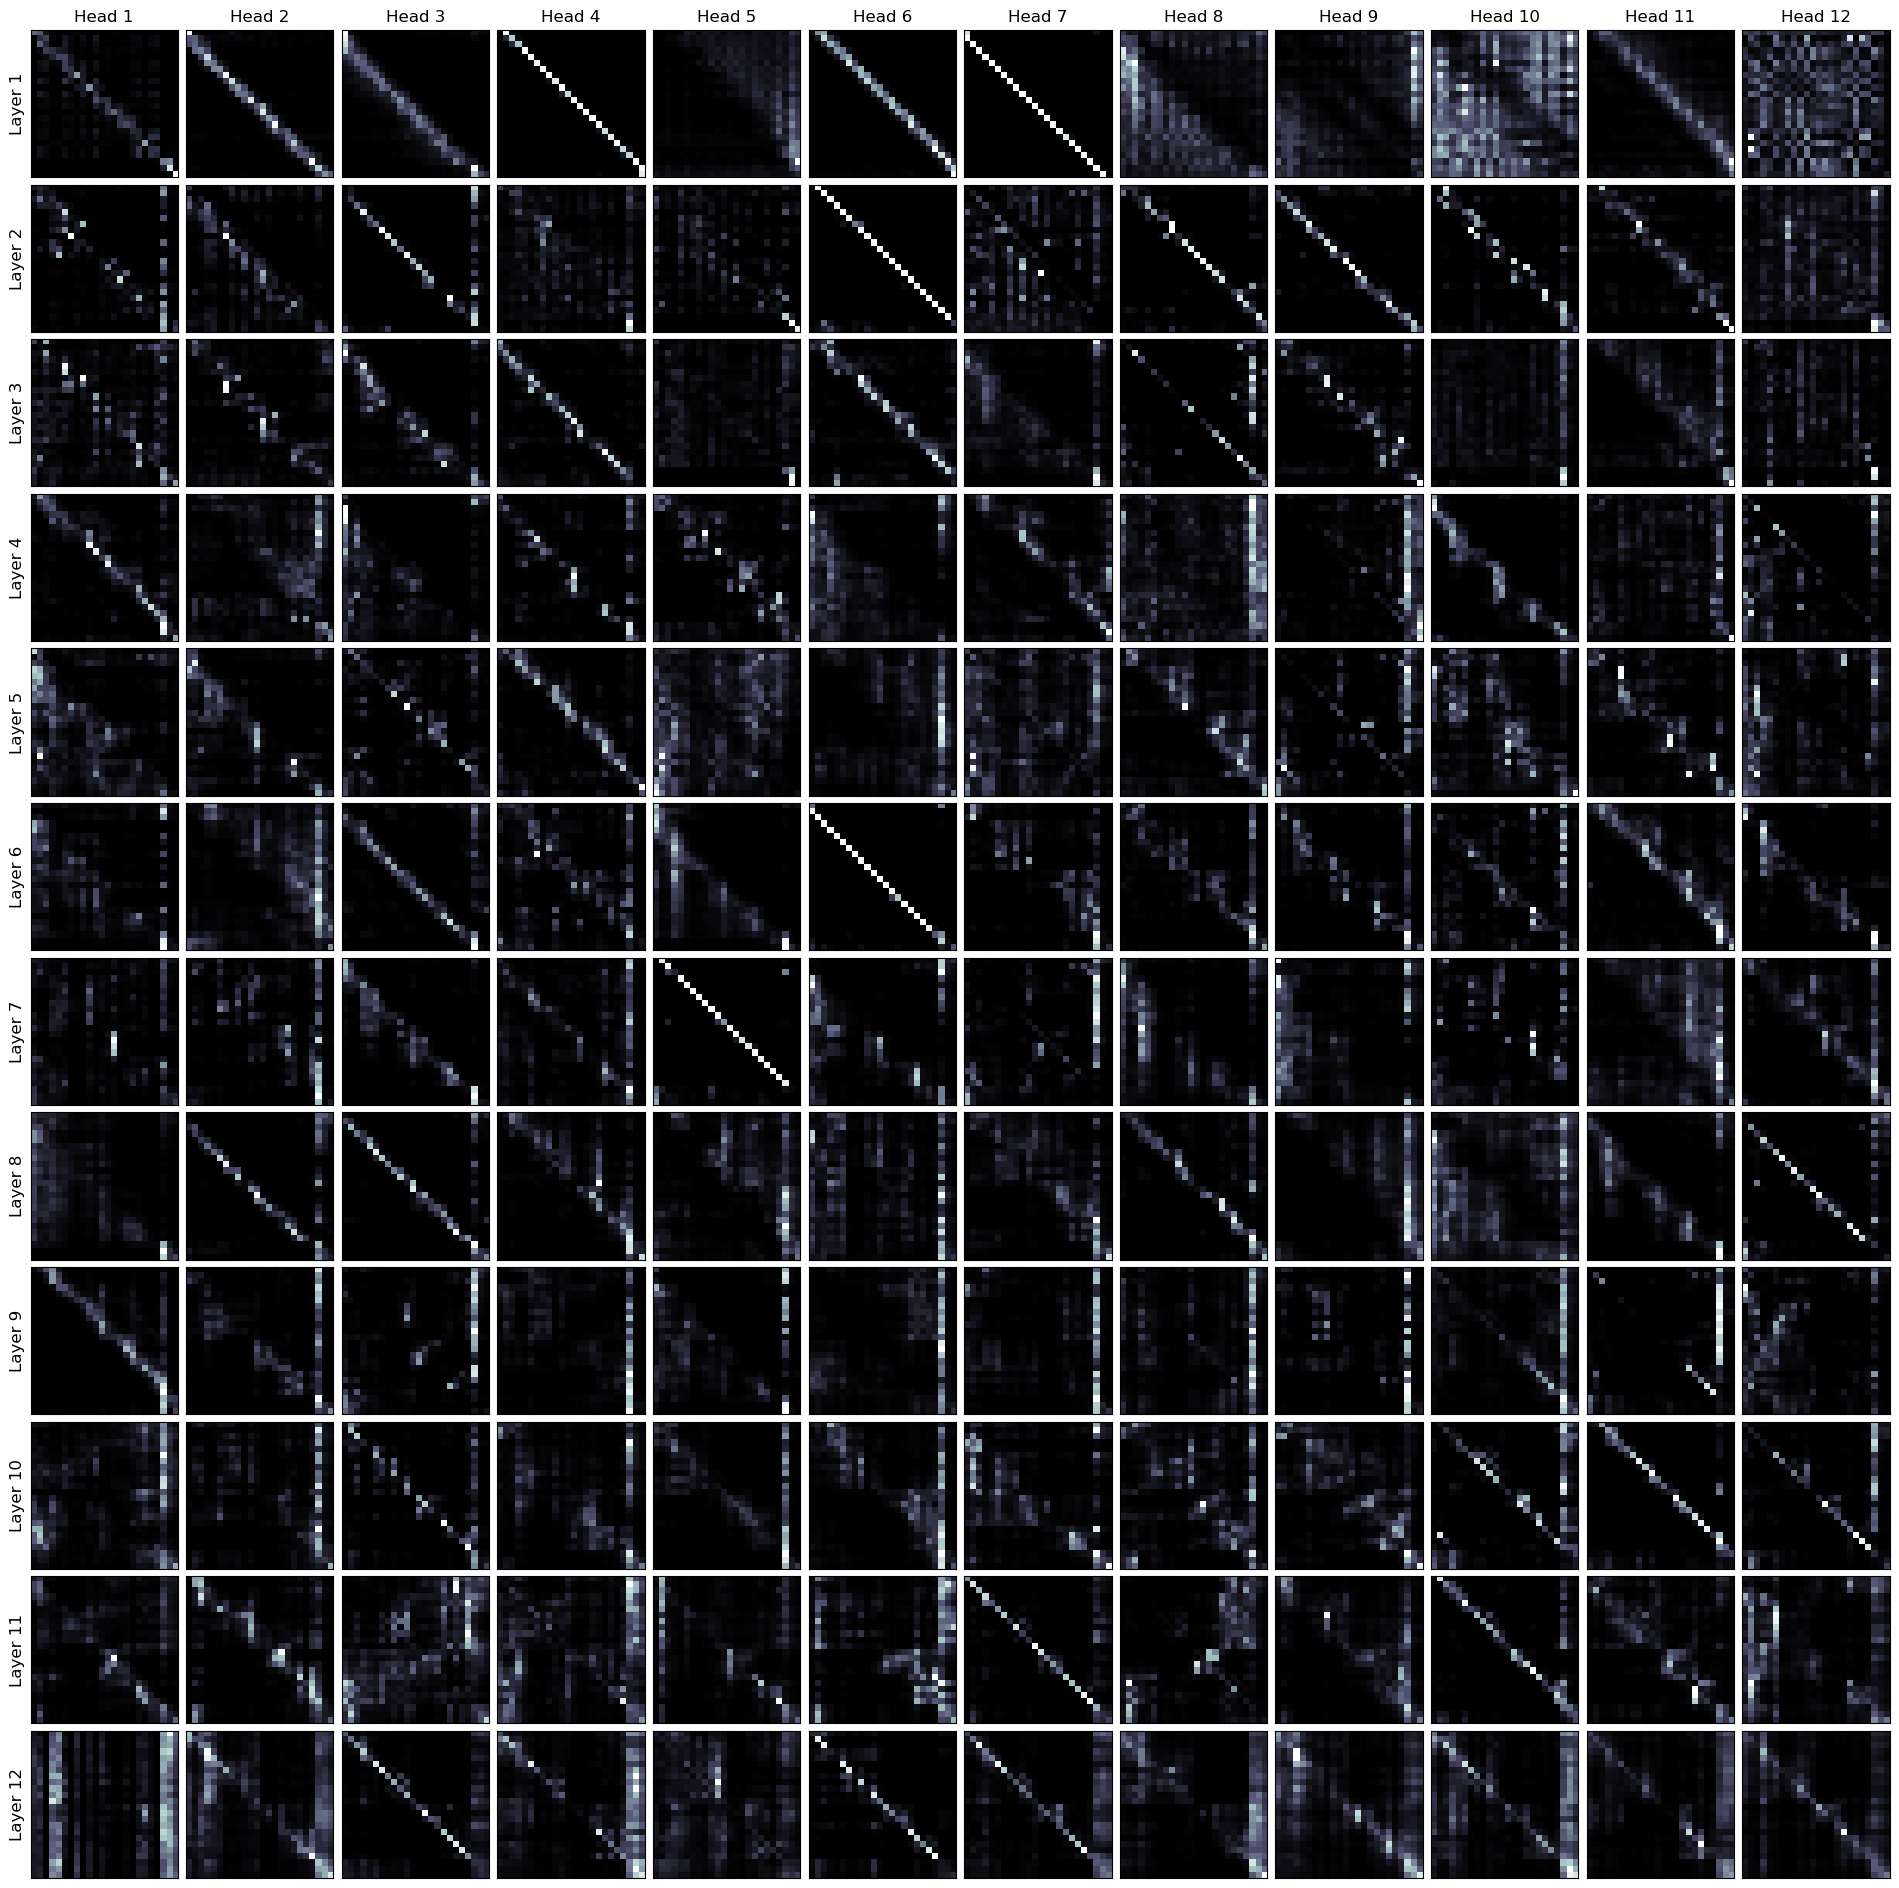

In [12]:
fig = plt.figure(figsize=(24.0, 24.0))

num_rows = model.config.n_layer
num_cols = model.config.n_head

gs = fig.add_gridspec(num_rows, num_cols, hspace=0.05, wspace=0.05)

for row in range(num_rows):
    layer_attention_maps = outputs["attentions"][row].detach().numpy()  # (batch=1, n_token, n_token, num_heads)
    for col in range(num_cols):
        ax = fig.add_subplot(gs[row, col])
        ax.matshow(layer_attention_maps[0, col, :, :], cmap="bone")
        if col == 0:
            ax.set_ylabel(f"Layer {row + 1}", fontsize=12)
        if row == 0:
            ax.set_title(f"Head {col + 1}", fontsize=12)
          
        # Hide x and y ticks:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

plt.show()